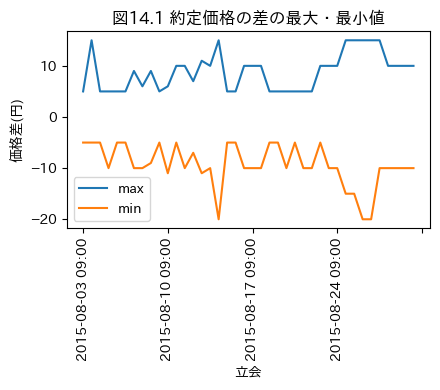

In [8]:
plotanalysis(maxmin,'立会','価格差(円)',\
             '図14.1 約定価格の差の最大・最小値')

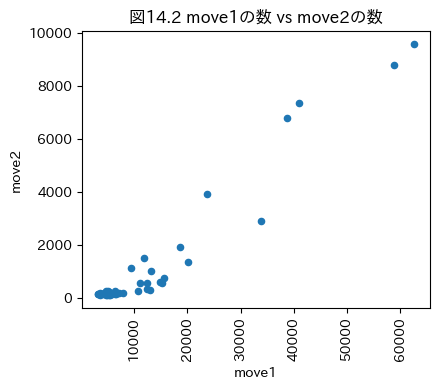

In [9]:
scatteranalysis(move,'move1','move2',"図14.2 move1の数 vs move2の数")

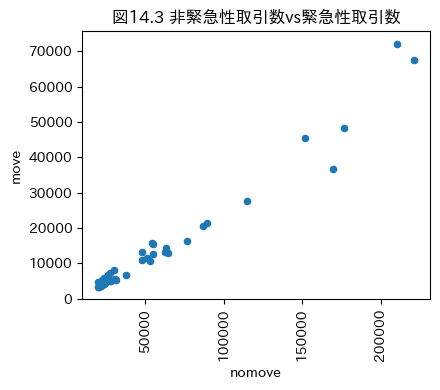

In [10]:
scatteranalysis(results,'nomove','move',"図14.3 非緊急性取引数vs緊急性取引数")

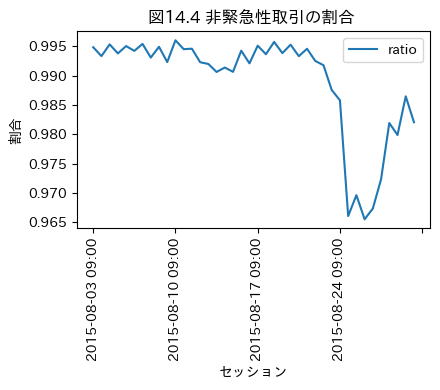

In [11]:
plotanalysis(ratio,'セッション','割合','図14.4 非緊急性取引の割合 ')

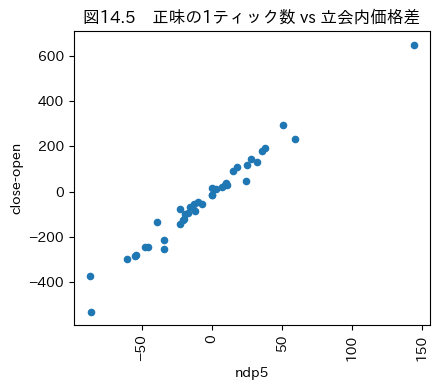

In [12]:
scatteranalysis(condp5,'ndp5','close-open',\
                '図14.5　正味の1ティック数 vs 立会内価格差')

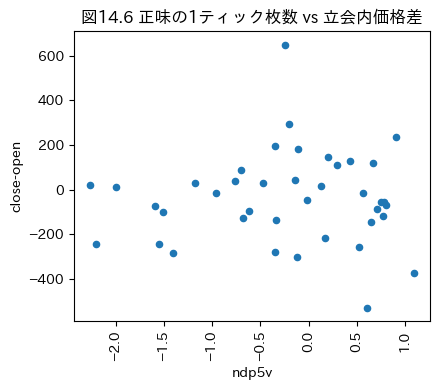

In [13]:
scatteranalysis(condp5v,'ndp5v','close-open',\
                '図14.6 正味の1ティック枚数 vs 立会内価格差')

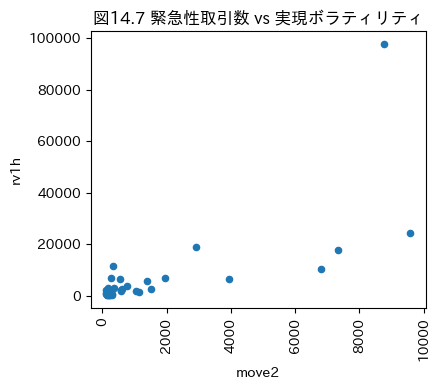

In [14]:
scatteranalysis(rv,'move2','rv1h','図14.7 緊急性取引数 vs 実現ボラティリティ')

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import japanize_matplotlib

from datetime import datetime #, date,time
import pandas as pd

In [2]:
def itayose(tmp):
    price=tmp.copy()
    lenprice=len(price)
    p0=price.Price.iloc[0] 
    p9=price.Price.iloc[-1] 
    for k,price0 in enumerate(price.Price):#itayose open
        if price0!=p0:
            break
    price_r=price.iloc[::-1]
    for kk,price0 in enumerate(price_r.Price):#itayose close
        if price0!=p9:
            break
    return price[k:-kk-1].copy(),p0,p9#zaraba market  

In [3]:
def analysis(tsd):
    indexdates=pd.unique(tsd.index.date)
    results=[];maxmin=[];rv=[];rv1h=[];moves=[];condp5=[];condp5v=[]
    dps=[];dpsv=[];ratio=[]
    da=[]
    def stats(tmp,dt):
        price0,p0,p9=itayose(tmp)      
        dp=price0.Price.diff().dropna()
        price0['dp']=price0.Price.diff()
        price0['BestBid0']=price0.BestBid.shift(1)
        price0['BestAsk0']=price0.BestAsk.shift(1)
        price0['bas']=(price0.BestBid==price0.BestBid0)\
            &(price0.BestAsk==price0.BestAsk0)#bid ask stable
        price0['move']=(~price0.bas)&((price0.Price>price0.BestAsk0)
             |(price0.Price<price0.BestBid0)) 
        move=len(price0)-len(dp[dp==0])
        move1=price0[(price0.bas)&(price0.dp!=0)].dp.count()
        move2=price0[(~price0.bas)&(price0.dp!=0)].dp.count()
        dps.append([len(dp[dp==5]),len(dp[dp==-5]),
                   len(dp[dp==10]),len(dp[dp==-10]),
                   len(dp[dp==15]),len(dp[dp==-15]),
                   len(dp[dp==20]),len(dp[dp==-20])])
        dpsv.append([price0[price0.dp==5].Volume.mean(),
                     price0[price0.dp==-5].Volume.mean(),
                     price0[price0.dp==10].Volume.mean(),
                     price0[price0.dp==-10].Volume.mean(),
                     price0[price0.dp==15].Volume.mean(),
                     price0[price0.dp==-15].Volume.mean(),
                     price0[price0.dp==20].Volume.mean(),
                     price0[price0.dp==-20].Volume.mean()])
        results.append([len(price0),len(dp[dp==0]),move])
        maxmin.append([max(dp),min(dp)])
        moves.append([move1,move2])
        rv1h=((tmp.Price.resample('1h').last().diff())**2).sum()
        rv.append([sum(dp**2)/dt,rv1h/dt,move2])
        ratio.append((len(dp[dp==0])+move1)/len(price0))
        condp5.append([p9-p0,len(dp[dp==5])-len(dp[dp==-5])])
        tmp=price0[price0.dp==5].Volume.mean()\
            -price0[price0.dp==-5].Volume.mean()
        condp5v.append([p9-p0,tmp])
        
    for indexdate,indexdate1 in zip(indexdates[:-1],indexdates[1:]):
        tmp=pd.DataFrame()
        tmp=tsd.loc[str(indexdate)+' 8:45:00+09:00':
                    str(indexdate)+' 15:15:00+09:00']
        if not tmp.empty:
            da.append(str(indexdate)+' 09:00')
            stats(tmp,6.5)
        tmp=pd.DataFrame()
        tmp=tsd.loc[str(indexdate)+' 16:30:00+09:00':
                    str(indexdate1)+' 6:00:00+09:00']
        if not tmp.empty:
            da.append(str(indexdate)+' 16:30')
            stats(tmp,14.5)
    maxmin=pd.DataFrame(maxmin,index=da,columns=['max','min'])
    results=pd.DataFrame(results,index=da,columns=['all','nomove','move'])
    rv=pd.DataFrame(rv,index=da,columns=['rv','rv1h','move2'])
    dps=pd.DataFrame(dps,index=da,
                     columns=['+5','-5','+10','-10','+15','-15','+20','-20'])
    move=pd.DataFrame(moves,index=da,columns=['move1','move2'])
    ratio=pd.DataFrame(ratio,index=da,columns=['ratio'])
    ndp5=dps.iloc[:,0:1].values-dps.iloc[:,1:2].values
    condp5=pd.DataFrame(condp5,index=da,columns=['close-open','ndp5'])
    condp5v=pd.DataFrame(condp5v,index=da,columns=['close-open','ndp5v'])
    return maxmin,results,rv,dps,dpsv,move,ratio,condp5,condp5v

In [4]:
def plotanalysis(data,xlabel,ylabel,title):
    data.plot(figsize=(4.5,4))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.savefig(title[:5]+'.jpeg',dpi=600)
    plt.show()

In [5]:
def scatteranalysis(data,x,y,title):
    data.plot.scatter(x=x,y=y,figsize=(4.5,4))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.savefig(title[:5]+'.jpeg',dpi=600)
    plt.show()

In [6]:
buf_path="C:/users/hm201/documents/Database/n225/tick/"
filenames=["n225m201508Sep.csv"]
if __name__ == "__main__":    
    start_now=datetime.now()
    for i,filename in enumerate(filenames):
        ts=pd.read_csv(buf_path+filename,
                        index_col=0,header=0,parse_dates=True) 
        if i==0:
            tsd=ts
        else:
            tsd=pd.concat([tsd,ts])  
        tsd=tsd.tz_convert('Asia/Tokyo')            
        print(tsd.index[0],len(tsd))
    print(datetime.now()-start_now,'-----------------------')    

2015-08-03 09:00:00+09:00 3070843
0:00:16.160886 -----------------------


In [7]:
maxmin,results,rv,dps,dpsv,move,ratio,condp5,condp5v=analysis(tsd)